### Import Libraries

In [1]:
# import the neccesary libraries
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn import preprocessing
from itertools import islice
import seaborn as sns
from scipy.stats import binom
from scipy.stats import norm
import statsmodels.stats.api as sms
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import preprocessing

### Import Project Classes
The data module is concerned with pre-processing and data exploration while the model class is concerned with model generation and comparison

In [2]:
# import modules from this project
import data
from model import Model

### Load the data

In [3]:
data_frame = pd.read_csv("dataset/bank-additional-full.csv",sep=';'  , engine='python')

### Creating Instances of the preprocessing and model classes.

In [4]:
# initialize the modelling and preprocessing classes
processor = data.PreProcessing(data_frame)
model = Model()

## Explanatory Data Analysis
### Target Imbalance

The following plot shows the dataset is a victim of class imbalance.

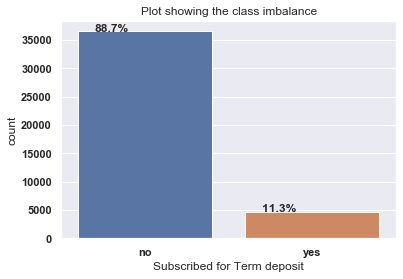

In [27]:
# use the plot_target_imbalance method from the preprocessing class
processor.plot_target_imbalance()

### Outlier Detection
The following plots show we have many outliers in age and duration. The box plots of both classes overlap quite a lot for age, this show age is not such a separating column. The difference b/n medians of yes and no for euribor3m shows that it is a separating class.

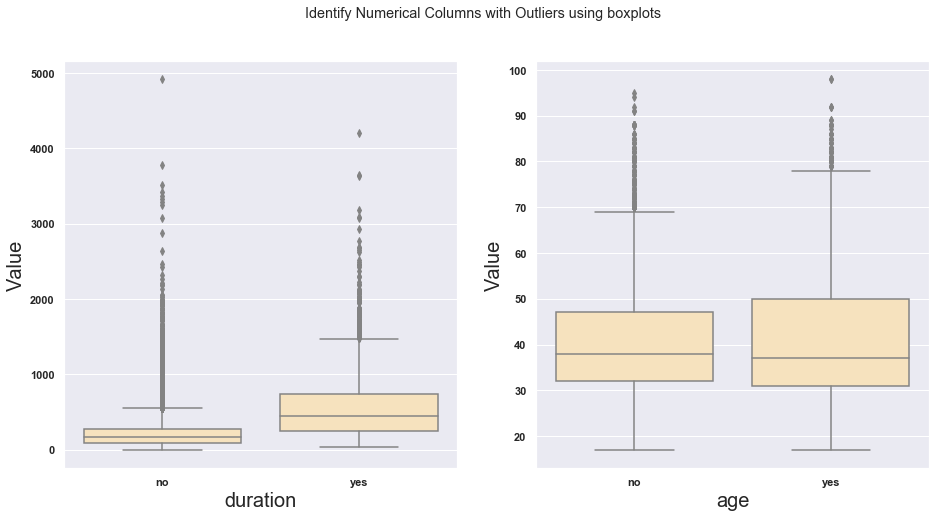

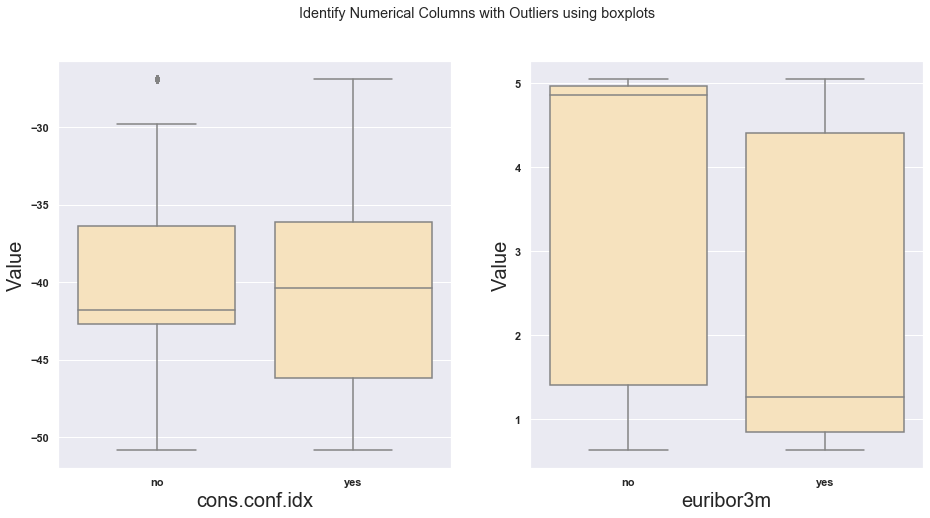

In [6]:
processor.detect_outliers_boxplot(['duration','age','cons.conf.idx','euribor3m'])

#### Treating outliers by replacing them with medians. 

In [7]:
processor.handle_outliers(['duration','age','cons.conf.idx'])

### Check if outliers are treated
The following plots show that the outliers have been treated.

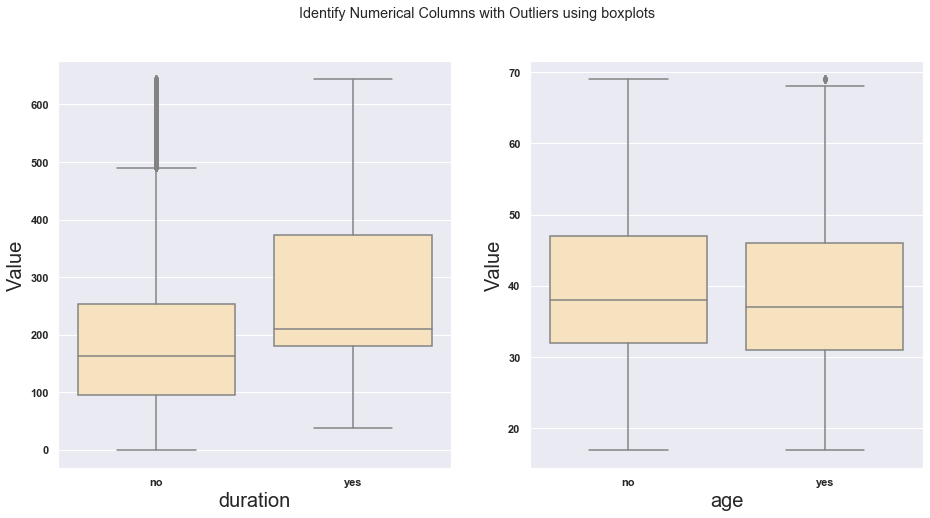

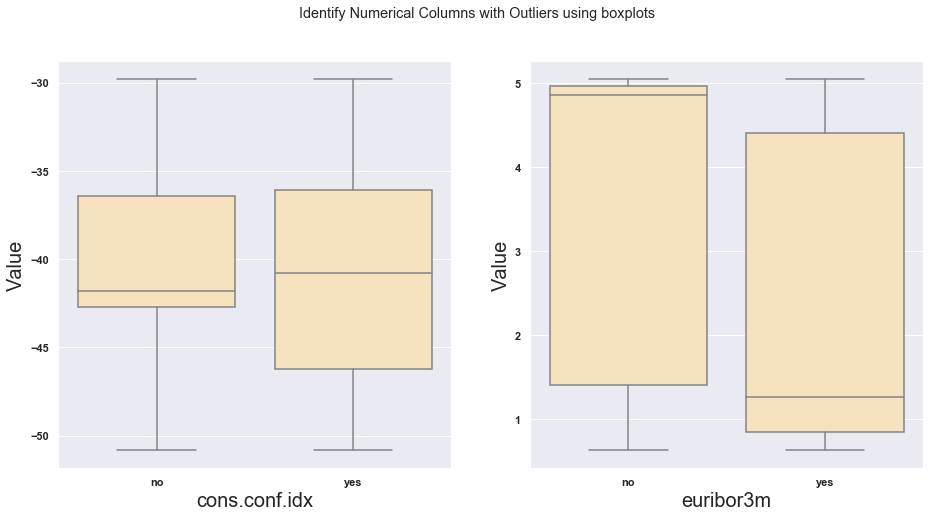

In [8]:
processor.detect_outliers_boxplot(['duration','age','cons.conf.idx','euribor3m'])

### Effects of categorical variables on the target variable.
In the subsequent plots the counts of all people who subscribed and those who didn't are shown as per each category of the catagorical variable.

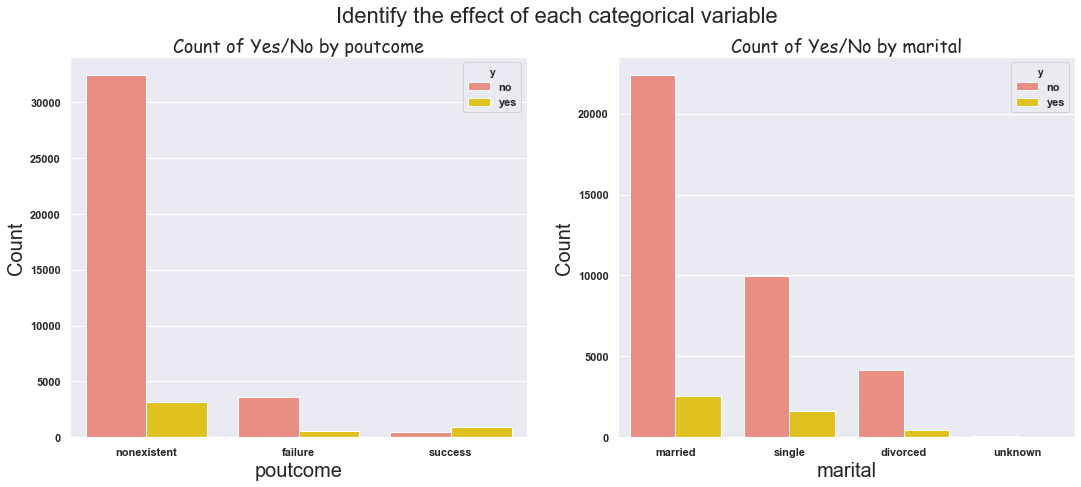

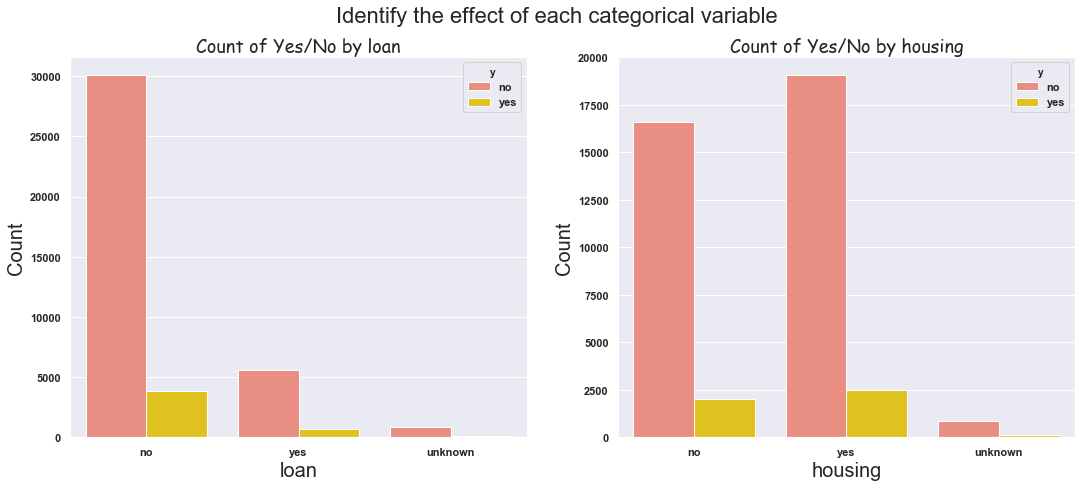

In [9]:
# use the plot_multiple_categorical_against_target method of the PreProcessing class
# to plot the count of each categorical variable with the target as a hue
processor.plot_multiple_categorical_against_target(['poutcome','marital','loan','housing'])

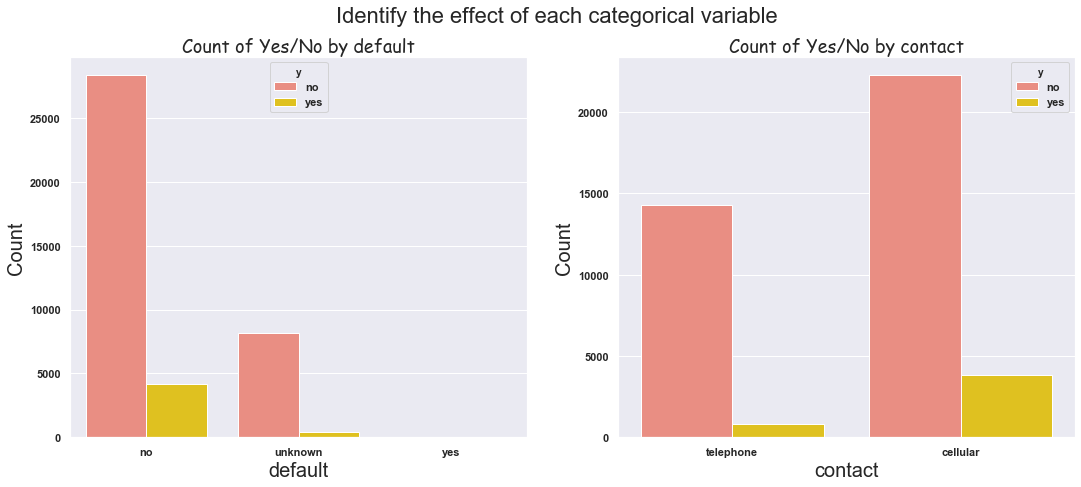

In [10]:
processor.plot_multiple_categorical_against_target(['default','contact'])

### Count of Yes/No by Education

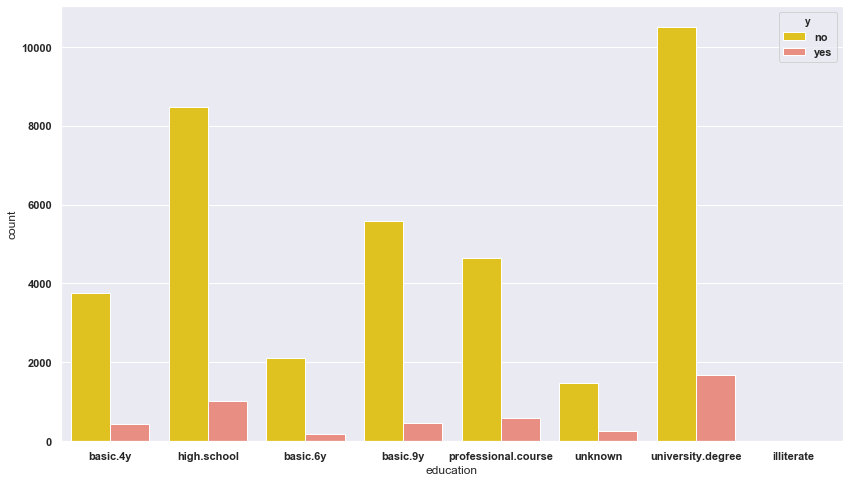

In [11]:
processor.plot_single_categorical_against_target('education')

#### The following plot shows day of week does not help very much when it comes to predicting the target variable. 

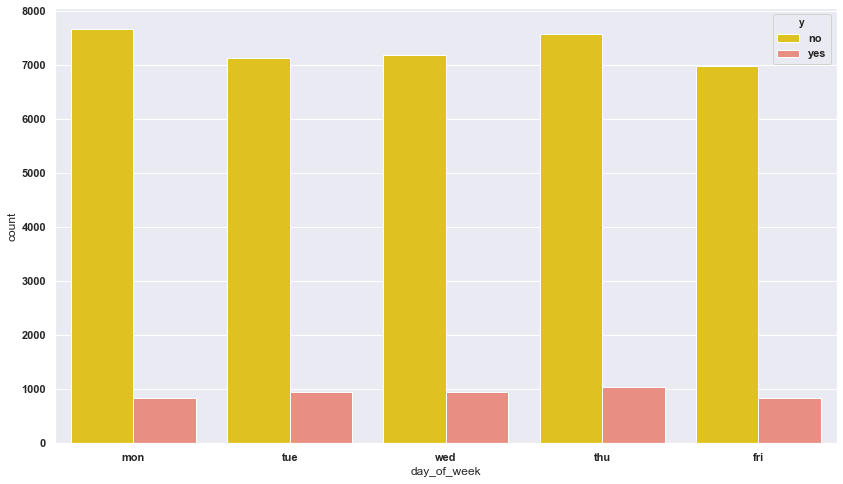

In [12]:
processor.plot_single_categorical_against_target('day_of_week')

### Histograms of numerical columns against the target column per each class
Looking at the age plot, the number of people who responded in the affirmative to the campaign goes up between 23 and 40 age, but not nearly as dramatically as negative responses do.

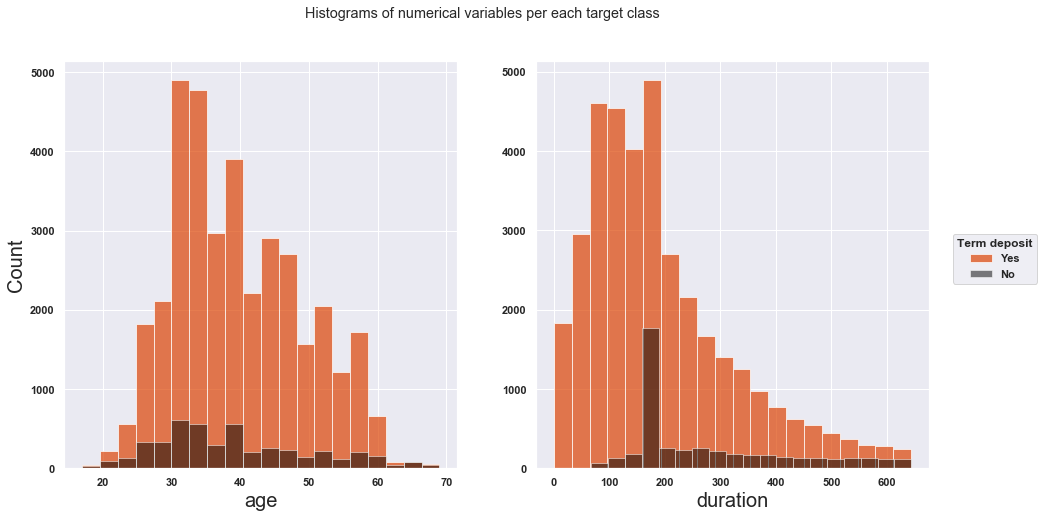

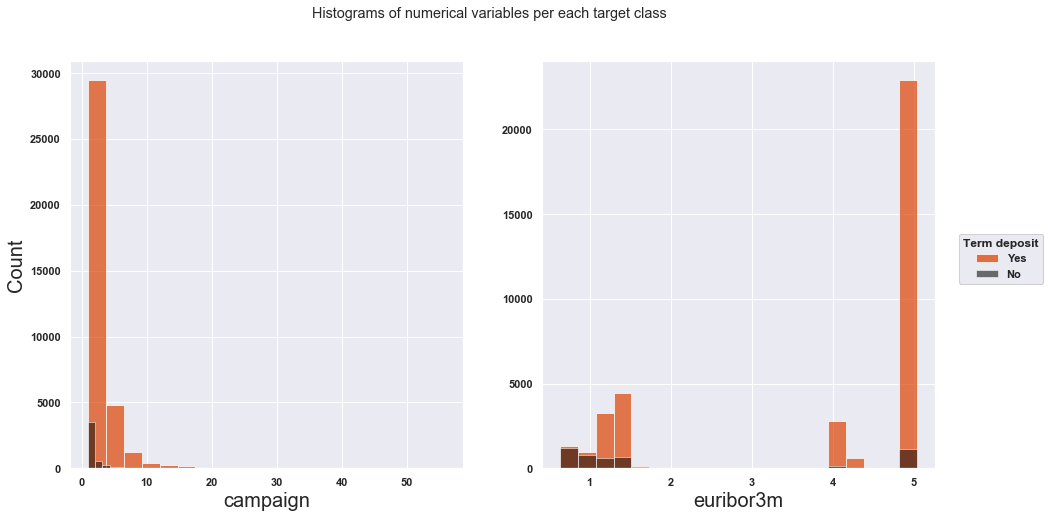

In [13]:
processor.plot_hist_against_target(['age','duration','campaign','euribor3m'])

### Correlation b/n numerical variables
The emp.var.rate, cons.price.idx, euribor3m and nr.employed features have very high correlation. With euribor3m and nr.employed having the highest correlation of 0.95!

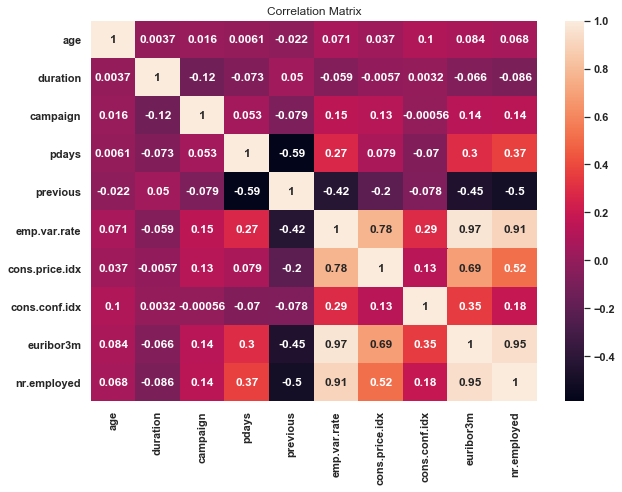

In [14]:
# plot the correlation heat_map
processor.plot_correletion_matrix()

### Distribution plots of numerical columns
The following are histograms of some numerical columns

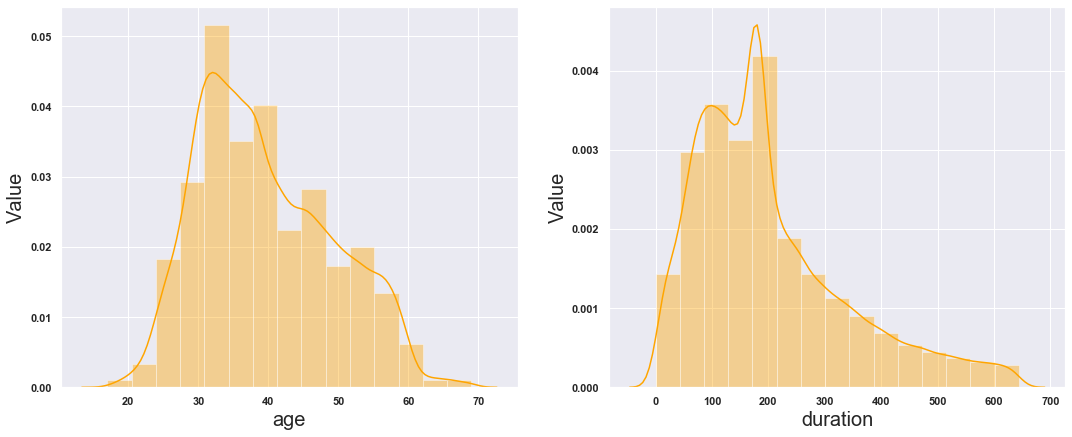

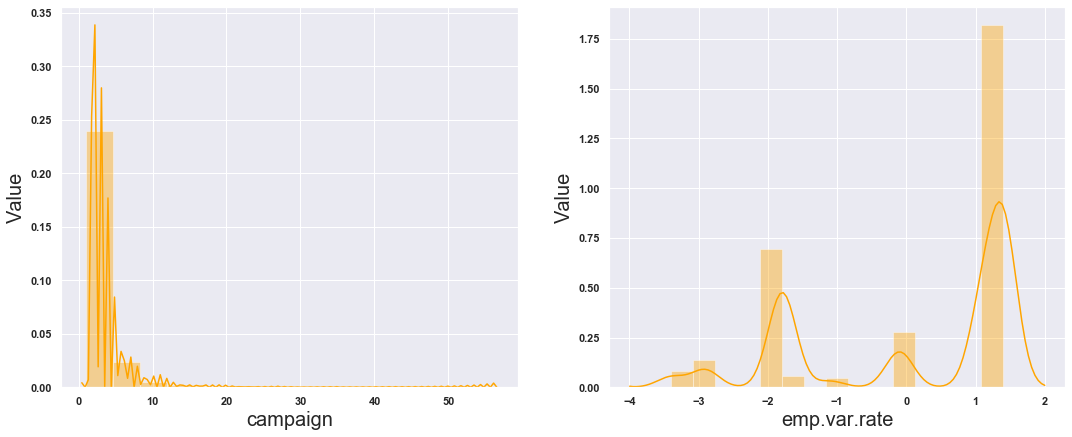

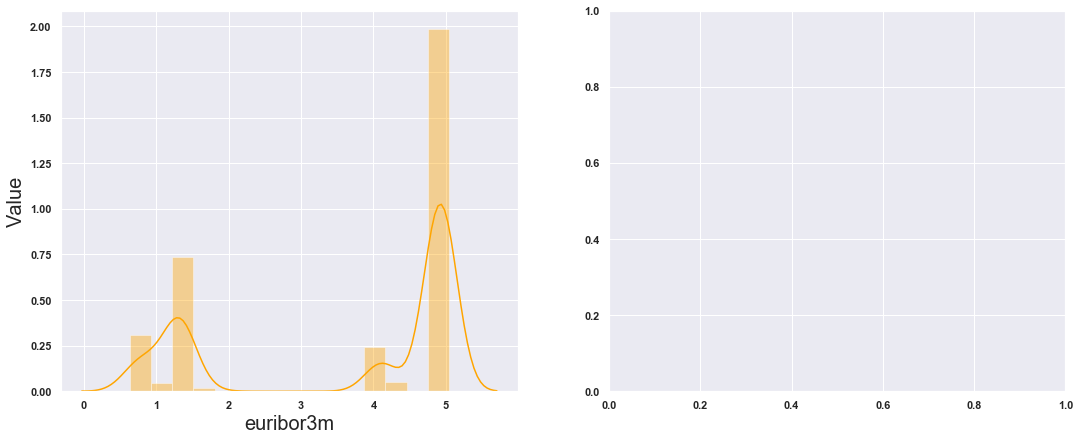

In [15]:
processor.plot_distribution(['age','duration','campaign','emp.var.rate','euribor3m'])

## Feature Engineerinig
### Assign a new feature 'Year' to each row


In [16]:
processor.assign_years()
processor.data_frame.sample(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,Year
17504,43.0,services,married,basic.6y,unknown,yes,yes,cellular,jul,mon,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no,2008
11600,28.0,admin.,single,university.degree,no,yes,no,telephone,jun,fri,...,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no,2008
17475,54.0,blue-collar,married,basic.4y,no,no,no,cellular,jul,mon,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no,2008
21789,33.0,admin.,married,university.degree,no,yes,no,cellular,aug,wed,...,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,no,2008
27600,48.0,unemployed,divorced,professional.course,no,yes,no,telephone,nov,fri,...,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,no,2008
2456,48.0,blue-collar,married,unknown,unknown,no,no,telephone,may,tue,...,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no,2008
8339,43.0,unemployed,married,basic.9y,no,no,no,telephone,jun,tue,...,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,no,2008
12895,25.0,admin.,single,high.school,no,no,yes,cellular,jul,tue,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no,2008
34928,41.0,entrepreneur,divorced,unknown,no,no,no,telephone,may,fri,...,999,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1,no,2009
9194,39.0,admin.,single,high.school,no,yes,no,telephone,jun,fri,...,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,no,2008


### Distinguish b/n numerical and categorical columns
Create lists holding the categorical and numerical columns

In [17]:
#Create lists holding the categorical columns
categorical_columns = ['job','marital','education',
                                         'default','loan','housing','contact',
                                         'month','poutcome']
#Create lists holding the numerical columns
numerical_columns = ['age','pdays','previous','emp.var.rate','cons.price.idx',
                                         'cons.conf.idx','euribor3m','nr.employed','Year']

### Create a column transformer
The following cell creates a column transformer that is responsible for both one hot encoding of categorical variables and standardization of numerical variables.This is then passed to the pipeline.

In [18]:
# a column transformer that handles both one hot encoding and standardization
column_transformer = processor.get_column_transformer(categorical_columns,numerical_columns,['duration','day_of_week'])

### Train/Test Split 
Split the data using the train_test_split() method of preprocessor class  which has a default of 20% for the test size

In [19]:
#split the data using the train_test_split() method of preprocessor class 
X_train,X_test,y_train,y_test=  processor.train_test_split()

### Add classifiers to be compared
The classifiers to be compared are Random Forest, Logistic Regressor, XGBoost and Multi Layer Perceptron. Then a pipe is created by making use of the above column transformer and the classifiers.

In [20]:
# add 4 classifier models to be compared
model.add_classifier(model.get_random_forest_classifier(),'Random Forest')
model.add_classifier(model.get_logistic_classifier(),'Logistic Regressor')
model.add_classifier(model.get_xgboost_classifier(),'XGBoost')
model.add_classifier(model.get_multi_perceptron(),'MLP')

#create a pipeline using the transformer and the above classifiers
model.create_pipes(column_transformer)

### Create K-Fold splitter
The K-Fold splitter will be used to compare models using cross_validation.

In [21]:
#use K-fold to split the training/validation data in 80:20 ratio
kfold = model.get_cross_validation_splitter(is_strattified = False)


In [22]:
#compare the models based on roc_auc
models_k_fold = model.compare_models(kfold , X_train, y_train,scoring = 'roc_auc')
#compare the models based on accuracy
models_k_fold_accuracy = model.compare_models(kfold , X_train, y_train,scoring='accuracy')


Iteration 1, loss = 0.64194254
Iteration 2, loss = 0.36559022
Iteration 3, loss = 0.33276312
Iteration 4, loss = 0.32101801
Iteration 5, loss = 0.31457806
Iteration 6, loss = 0.31046307
Iteration 7, loss = 0.30757475
Iteration 8, loss = 0.30535965
Iteration 9, loss = 0.30370498
Iteration 10, loss = 0.30239766
Iteration 11, loss = 0.30133397
Iteration 12, loss = 0.30049993
Iteration 13, loss = 0.29977899
Iteration 14, loss = 0.29920778
Iteration 15, loss = 0.29867679
Iteration 16, loss = 0.29828348
Iteration 17, loss = 0.29785900
Iteration 18, loss = 0.29753992
Iteration 19, loss = 0.29718536
Iteration 20, loss = 0.29688828
Iteration 21, loss = 0.29661353
Iteration 22, loss = 0.29635134
Iteration 23, loss = 0.29609275
Iteration 24, loss = 0.29584829
Iteration 25, loss = 0.29564254
Iteration 26, loss = 0.29543760
Iteration 27, loss = 0.29520910
Iteration 28, loss = 0.29503713
Iteration 29, loss = 0.29484560
Iteration 30, loss = 0.29467123
Iteration 31, loss = 0.29450737
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63927170
Iteration 2, loss = 0.36312255
Iteration 3, loss = 0.33164192
Iteration 4, loss = 0.32019176
Iteration 5, loss = 0.31396991
Iteration 6, loss = 0.30995604
Iteration 7, loss = 0.30714860
Iteration 8, loss = 0.30499688
Iteration 9, loss = 0.30337571
Iteration 10, loss = 0.30210506
Iteration 11, loss = 0.30110766
Iteration 12, loss = 0.30031758
Iteration 13, loss = 0.29956418
Iteration 14, loss = 0.29898871
Iteration 15, loss = 0.29848824
Iteration 16, loss = 0.29803265
Iteration 17, loss = 0.29762446
Iteration 18, loss = 0.29728876
Iteration 19, loss = 0.29696682
Iteration 20, loss = 0.29666509
Iteration 21, loss = 0.29640121
Iteration 22, loss = 0.29613626
Iteration 23, loss = 0.29592781
Iteration 24, loss = 0.29573604
Iteration 25, loss = 0.29551959
Iteration 26, loss = 0.29531609
Iteration 27, loss = 0.29515365
Iteration 28, loss = 0.29495564
Iteration 29, loss = 0.29477968
Iteration 30, loss = 0.29462553
Iteration 31, loss = 0.29447879
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.62620238
Iteration 2, loss = 0.36424802
Iteration 3, loss = 0.33241862
Iteration 4, loss = 0.32045275
Iteration 5, loss = 0.31386359
Iteration 6, loss = 0.30945947
Iteration 7, loss = 0.30621133
Iteration 8, loss = 0.30375903
Iteration 9, loss = 0.30186240
Iteration 10, loss = 0.30040491
Iteration 11, loss = 0.29926932
Iteration 12, loss = 0.29840130
Iteration 13, loss = 0.29769740
Iteration 14, loss = 0.29719314
Iteration 15, loss = 0.29674105
Iteration 16, loss = 0.29639397
Iteration 17, loss = 0.29605974
Iteration 18, loss = 0.29581000
Iteration 19, loss = 0.29554539
Iteration 20, loss = 0.29530913
Iteration 21, loss = 0.29507781
Iteration 22, loss = 0.29486883
Iteration 23, loss = 0.29469145
Iteration 24, loss = 0.29452782
Iteration 25, loss = 0.29433127
Iteration 26, loss = 0.29419900
Iteration 27, loss = 0.29400718
Iteration 28, loss = 0.29385941
Iteration 29, loss = 0.29371727
Iteration 30, loss = 0.29358819
Iteration 31, loss = 0.29347631
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63971445
Iteration 2, loss = 0.36442413
Iteration 3, loss = 0.33223785
Iteration 4, loss = 0.32076061
Iteration 5, loss = 0.31454600
Iteration 6, loss = 0.31058061
Iteration 7, loss = 0.30773252
Iteration 8, loss = 0.30564010
Iteration 9, loss = 0.30403853
Iteration 10, loss = 0.30278485
Iteration 11, loss = 0.30180170
Iteration 12, loss = 0.30099176
Iteration 13, loss = 0.30029492
Iteration 14, loss = 0.29971481
Iteration 15, loss = 0.29922124
Iteration 16, loss = 0.29877543
Iteration 17, loss = 0.29837439
Iteration 18, loss = 0.29798091
Iteration 19, loss = 0.29765687
Iteration 20, loss = 0.29735610
Iteration 21, loss = 0.29709308
Iteration 22, loss = 0.29683601
Iteration 23, loss = 0.29661846
Iteration 24, loss = 0.29640184
Iteration 25, loss = 0.29621771
Iteration 26, loss = 0.29600405
Iteration 27, loss = 0.29585197
Iteration 28, loss = 0.29569044
Iteration 29, loss = 0.29553568
Iteration 30, loss = 0.29537352
Iteration 31, loss = 0.29524124
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63667783
Iteration 2, loss = 0.36317407
Iteration 3, loss = 0.33141790
Iteration 4, loss = 0.31988062
Iteration 5, loss = 0.31360110
Iteration 6, loss = 0.30953233
Iteration 7, loss = 0.30664514
Iteration 8, loss = 0.30455103
Iteration 9, loss = 0.30292931
Iteration 10, loss = 0.30166914
Iteration 11, loss = 0.30068499
Iteration 12, loss = 0.29986469
Iteration 13, loss = 0.29918163
Iteration 14, loss = 0.29860370
Iteration 15, loss = 0.29815235
Iteration 16, loss = 0.29773543
Iteration 17, loss = 0.29735397
Iteration 18, loss = 0.29703379
Iteration 19, loss = 0.29672541
Iteration 20, loss = 0.29642966
Iteration 21, loss = 0.29617991
Iteration 22, loss = 0.29594404
Iteration 23, loss = 0.29571935
Iteration 24, loss = 0.29549102
Iteration 25, loss = 0.29531770
Iteration 26, loss = 0.29514234
Iteration 27, loss = 0.29494691
Iteration 28, loss = 0.29478785
Iteration 29, loss = 0.29464278
Iteration 30, loss = 0.29450080
Iteration 31, loss = 0.29436380
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.64194265
Iteration 2, loss = 0.36559029
Iteration 3, loss = 0.33276318
Iteration 4, loss = 0.32101807
Iteration 5, loss = 0.31457812
Iteration 6, loss = 0.31046313
Iteration 7, loss = 0.30757482
Iteration 8, loss = 0.30535972
Iteration 9, loss = 0.30370504
Iteration 10, loss = 0.30239771
Iteration 11, loss = 0.30133402
Iteration 12, loss = 0.30049998
Iteration 13, loss = 0.29977903
Iteration 14, loss = 0.29920782
Iteration 15, loss = 0.29867683
Iteration 16, loss = 0.29828352
Iteration 17, loss = 0.29785904
Iteration 18, loss = 0.29753995
Iteration 19, loss = 0.29718539
Iteration 20, loss = 0.29688831
Iteration 21, loss = 0.29661357
Iteration 22, loss = 0.29635139
Iteration 23, loss = 0.29609279
Iteration 24, loss = 0.29584834
Iteration 25, loss = 0.29564258
Iteration 26, loss = 0.29543764
Iteration 27, loss = 0.29520914
Iteration 28, loss = 0.29503701
Iteration 29, loss = 0.29484559
Iteration 30, loss = 0.29467119
Iteration 31, loss = 0.29450725
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63927175
Iteration 2, loss = 0.36312258
Iteration 3, loss = 0.33164184
Iteration 4, loss = 0.32019172
Iteration 5, loss = 0.31396989
Iteration 6, loss = 0.30995601
Iteration 7, loss = 0.30714858
Iteration 8, loss = 0.30499688
Iteration 9, loss = 0.30337568
Iteration 10, loss = 0.30210505
Iteration 11, loss = 0.30110764
Iteration 12, loss = 0.30031755
Iteration 13, loss = 0.29956398
Iteration 14, loss = 0.29898855
Iteration 15, loss = 0.29848808
Iteration 16, loss = 0.29803251
Iteration 17, loss = 0.29762417
Iteration 18, loss = 0.29728872
Iteration 19, loss = 0.29696678
Iteration 20, loss = 0.29666506
Iteration 21, loss = 0.29640111
Iteration 22, loss = 0.29613621
Iteration 23, loss = 0.29592774
Iteration 24, loss = 0.29573598
Iteration 25, loss = 0.29551983
Iteration 26, loss = 0.29531600
Iteration 27, loss = 0.29515388
Iteration 28, loss = 0.29495592
Iteration 29, loss = 0.29477988
Iteration 30, loss = 0.29462568
Iteration 31, loss = 0.29447862
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.62620230
Iteration 2, loss = 0.36424797
Iteration 3, loss = 0.33241857
Iteration 4, loss = 0.32045270
Iteration 5, loss = 0.31386359
Iteration 6, loss = 0.30945949
Iteration 7, loss = 0.30621132
Iteration 8, loss = 0.30375899
Iteration 9, loss = 0.30186237
Iteration 10, loss = 0.30040488
Iteration 11, loss = 0.29926935
Iteration 12, loss = 0.29840123
Iteration 13, loss = 0.29769737
Iteration 14, loss = 0.29719316
Iteration 15, loss = 0.29674113
Iteration 16, loss = 0.29639382
Iteration 17, loss = 0.29605984
Iteration 18, loss = 0.29580978
Iteration 19, loss = 0.29554576
Iteration 20, loss = 0.29530901
Iteration 21, loss = 0.29507752
Iteration 22, loss = 0.29486925
Iteration 23, loss = 0.29469090
Iteration 24, loss = 0.29452749
Iteration 25, loss = 0.29433091
Iteration 26, loss = 0.29419853
Iteration 27, loss = 0.29400682
Iteration 28, loss = 0.29385875
Iteration 29, loss = 0.29371674
Iteration 30, loss = 0.29358784
Iteration 31, loss = 0.29347571
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63971443
Iteration 2, loss = 0.36442411
Iteration 3, loss = 0.33223784
Iteration 4, loss = 0.32076060
Iteration 5, loss = 0.31454598
Iteration 6, loss = 0.31058060
Iteration 7, loss = 0.30773251
Iteration 8, loss = 0.30564009
Iteration 9, loss = 0.30403854
Iteration 10, loss = 0.30278487
Iteration 11, loss = 0.30180172
Iteration 12, loss = 0.30099179
Iteration 13, loss = 0.30029495
Iteration 14, loss = 0.29971487
Iteration 15, loss = 0.29922131
Iteration 16, loss = 0.29877550
Iteration 17, loss = 0.29837447
Iteration 18, loss = 0.29798100
Iteration 19, loss = 0.29765690
Iteration 20, loss = 0.29735625
Iteration 21, loss = 0.29709318
Iteration 22, loss = 0.29683609
Iteration 23, loss = 0.29661854
Iteration 24, loss = 0.29640192
Iteration 25, loss = 0.29621779
Iteration 26, loss = 0.29600416
Iteration 27, loss = 0.29585207
Iteration 28, loss = 0.29569057
Iteration 29, loss = 0.29553582
Iteration 30, loss = 0.29537365
Iteration 31, loss = 0.29524137
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63667800
Iteration 2, loss = 0.36317406
Iteration 3, loss = 0.33141789
Iteration 4, loss = 0.31988061
Iteration 5, loss = 0.31360109
Iteration 6, loss = 0.30953232
Iteration 7, loss = 0.30664514
Iteration 8, loss = 0.30455103
Iteration 9, loss = 0.30292930
Iteration 10, loss = 0.30166913
Iteration 11, loss = 0.30068499
Iteration 12, loss = 0.29986469
Iteration 13, loss = 0.29918160
Iteration 14, loss = 0.29860375
Iteration 15, loss = 0.29815230
Iteration 16, loss = 0.29773541
Iteration 17, loss = 0.29735396
Iteration 18, loss = 0.29703372
Iteration 19, loss = 0.29672535
Iteration 20, loss = 0.29642956
Iteration 21, loss = 0.29618002
Iteration 22, loss = 0.29594402
Iteration 23, loss = 0.29571935
Iteration 24, loss = 0.29549108
Iteration 25, loss = 0.29531789
Iteration 26, loss = 0.29514245
Iteration 27, loss = 0.29494777
Iteration 28, loss = 0.29478815
Iteration 29, loss = 0.29464362
Iteration 30, loss = 0.29450114
Iteration 31, loss = 0.29436414
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Label Binarizer
Fit target to Label Binarizer to identify which target class is positive so that recall, precision and f1 are done

In [23]:
# Label Binarizer to identify which target class is positive
lb = preprocessing.LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(y_train)])

#compare the models based on recall
models_k_fold_recall = model.compare_models(kfold , X_train, y_train,scoring='recall')

#compare the models based on precision
models_k_fold_precision = model.compare_models(kfold , X_train, y_train,scoring='precision')

#compare the models based on f1_score
models_k_fold_f1 = model.compare_models(kfold , X_train, y_train,scoring='f1')


Iteration 1, loss = 0.64194264
Iteration 2, loss = 0.36559029
Iteration 3, loss = 0.33276318
Iteration 4, loss = 0.32101806
Iteration 5, loss = 0.31457811
Iteration 6, loss = 0.31046312
Iteration 7, loss = 0.30757481
Iteration 8, loss = 0.30535971
Iteration 9, loss = 0.30370503
Iteration 10, loss = 0.30239770
Iteration 11, loss = 0.30133401
Iteration 12, loss = 0.30049997
Iteration 13, loss = 0.29977903
Iteration 14, loss = 0.29920782
Iteration 15, loss = 0.29867682
Iteration 16, loss = 0.29828351
Iteration 17, loss = 0.29785903
Iteration 18, loss = 0.29753995
Iteration 19, loss = 0.29718539
Iteration 20, loss = 0.29688831
Iteration 21, loss = 0.29661357
Iteration 22, loss = 0.29635138
Iteration 23, loss = 0.29609279
Iteration 24, loss = 0.29584833
Iteration 25, loss = 0.29564258
Iteration 26, loss = 0.29543763
Iteration 27, loss = 0.29520914
Iteration 28, loss = 0.29503701
Iteration 29, loss = 0.29484558
Iteration 30, loss = 0.29467119
Iteration 31, loss = 0.29450724
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63927169
Iteration 2, loss = 0.36312229
Iteration 3, loss = 0.33164182
Iteration 4, loss = 0.32019167
Iteration 5, loss = 0.31396980
Iteration 6, loss = 0.30995594
Iteration 7, loss = 0.30714847
Iteration 8, loss = 0.30499674
Iteration 9, loss = 0.30337558
Iteration 10, loss = 0.30210492
Iteration 11, loss = 0.30110742
Iteration 12, loss = 0.30031716
Iteration 13, loss = 0.29956343
Iteration 14, loss = 0.29898817
Iteration 15, loss = 0.29848793
Iteration 16, loss = 0.29803167
Iteration 17, loss = 0.29762362
Iteration 18, loss = 0.29728801
Iteration 19, loss = 0.29696553
Iteration 20, loss = 0.29666389
Iteration 21, loss = 0.29640005
Iteration 22, loss = 0.29613487
Iteration 23, loss = 0.29592640
Iteration 24, loss = 0.29573410
Iteration 25, loss = 0.29551749
Iteration 26, loss = 0.29531353
Iteration 27, loss = 0.29515066
Iteration 28, loss = 0.29495207
Iteration 29, loss = 0.29477609
Iteration 30, loss = 0.29462103
Iteration 31, loss = 0.29447426
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.62620248
Iteration 2, loss = 0.36424808
Iteration 3, loss = 0.33241866
Iteration 4, loss = 0.32045280
Iteration 5, loss = 0.31386368
Iteration 6, loss = 0.30945958
Iteration 7, loss = 0.30621143
Iteration 8, loss = 0.30375911
Iteration 9, loss = 0.30186253
Iteration 10, loss = 0.30040502
Iteration 11, loss = 0.29926947
Iteration 12, loss = 0.29840144
Iteration 13, loss = 0.29769755
Iteration 14, loss = 0.29719338
Iteration 15, loss = 0.29674144
Iteration 16, loss = 0.29639415
Iteration 17, loss = 0.29606026
Iteration 18, loss = 0.29581044
Iteration 19, loss = 0.29554602
Iteration 20, loss = 0.29531010
Iteration 21, loss = 0.29507814
Iteration 22, loss = 0.29486931
Iteration 23, loss = 0.29469122
Iteration 24, loss = 0.29452799
Iteration 25, loss = 0.29433171
Iteration 26, loss = 0.29419939
Iteration 27, loss = 0.29400769
Iteration 28, loss = 0.29385981
Iteration 29, loss = 0.29371820
Iteration 30, loss = 0.29358941
Iteration 31, loss = 0.29347716
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63971436
Iteration 2, loss = 0.36442431
Iteration 3, loss = 0.33223798
Iteration 4, loss = 0.32076075
Iteration 5, loss = 0.31454614
Iteration 6, loss = 0.31058076
Iteration 7, loss = 0.30773257
Iteration 8, loss = 0.30564009
Iteration 9, loss = 0.30403857
Iteration 10, loss = 0.30278489
Iteration 11, loss = 0.30180174
Iteration 12, loss = 0.30099180
Iteration 13, loss = 0.30029495
Iteration 14, loss = 0.29971488
Iteration 15, loss = 0.29922130
Iteration 16, loss = 0.29877548
Iteration 17, loss = 0.29837437
Iteration 18, loss = 0.29798100
Iteration 19, loss = 0.29765698
Iteration 20, loss = 0.29735630
Iteration 21, loss = 0.29709316
Iteration 22, loss = 0.29683602
Iteration 23, loss = 0.29661871
Iteration 24, loss = 0.29640213
Iteration 25, loss = 0.29621789
Iteration 26, loss = 0.29600486
Iteration 27, loss = 0.29585257
Iteration 28, loss = 0.29569078
Iteration 29, loss = 0.29553635
Iteration 30, loss = 0.29537405
Iteration 31, loss = 0.29524166
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63667787
Iteration 2, loss = 0.36317410
Iteration 3, loss = 0.33141792
Iteration 4, loss = 0.31988064
Iteration 5, loss = 0.31360112
Iteration 6, loss = 0.30953235
Iteration 7, loss = 0.30664516
Iteration 8, loss = 0.30455105
Iteration 9, loss = 0.30292933
Iteration 10, loss = 0.30166915
Iteration 11, loss = 0.30068501
Iteration 12, loss = 0.29986471
Iteration 13, loss = 0.29918165
Iteration 14, loss = 0.29860372
Iteration 15, loss = 0.29815237
Iteration 16, loss = 0.29773546
Iteration 17, loss = 0.29735394
Iteration 18, loss = 0.29703374
Iteration 19, loss = 0.29672549
Iteration 20, loss = 0.29642967
Iteration 21, loss = 0.29617994
Iteration 22, loss = 0.29594402
Iteration 23, loss = 0.29571948
Iteration 24, loss = 0.29549100
Iteration 25, loss = 0.29531815
Iteration 26, loss = 0.29514278
Iteration 27, loss = 0.29494713
Iteration 28, loss = 0.29478778
Iteration 29, loss = 0.29464307
Iteration 30, loss = 0.29450073
Iteration 31, loss = 0.29436337
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.64194262
Iteration 2, loss = 0.36559027
Iteration 3, loss = 0.33276316
Iteration 4, loss = 0.32101804
Iteration 5, loss = 0.31457810
Iteration 6, loss = 0.31046311
Iteration 7, loss = 0.30757479
Iteration 8, loss = 0.30535969
Iteration 9, loss = 0.30370501
Iteration 10, loss = 0.30239768
Iteration 11, loss = 0.30133400
Iteration 12, loss = 0.30049995
Iteration 13, loss = 0.29977902
Iteration 14, loss = 0.29920781
Iteration 15, loss = 0.29867681
Iteration 16, loss = 0.29828350
Iteration 17, loss = 0.29785902
Iteration 18, loss = 0.29753993
Iteration 19, loss = 0.29718537
Iteration 20, loss = 0.29688829
Iteration 21, loss = 0.29661355
Iteration 22, loss = 0.29635136
Iteration 23, loss = 0.29609277
Iteration 24, loss = 0.29584832
Iteration 25, loss = 0.29564256
Iteration 26, loss = 0.29543762
Iteration 27, loss = 0.29520913
Iteration 28, loss = 0.29503699
Iteration 29, loss = 0.29484557
Iteration 30, loss = 0.29467118
Iteration 31, loss = 0.29450723
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63927175
Iteration 2, loss = 0.36312256
Iteration 3, loss = 0.33164195
Iteration 4, loss = 0.32019178
Iteration 5, loss = 0.31396994
Iteration 6, loss = 0.30995607
Iteration 7, loss = 0.30714863
Iteration 8, loss = 0.30499691
Iteration 9, loss = 0.30337573
Iteration 10, loss = 0.30210509
Iteration 11, loss = 0.30110770
Iteration 12, loss = 0.30031760
Iteration 13, loss = 0.29956416
Iteration 14, loss = 0.29898875
Iteration 15, loss = 0.29848825
Iteration 16, loss = 0.29803267
Iteration 17, loss = 0.29762430
Iteration 18, loss = 0.29728880
Iteration 19, loss = 0.29696681
Iteration 20, loss = 0.29666506
Iteration 21, loss = 0.29640125
Iteration 22, loss = 0.29613631
Iteration 23, loss = 0.29592784
Iteration 24, loss = 0.29573603
Iteration 25, loss = 0.29551985
Iteration 26, loss = 0.29531626
Iteration 27, loss = 0.29515379
Iteration 28, loss = 0.29495593
Iteration 29, loss = 0.29477996
Iteration 30, loss = 0.29462570
Iteration 31, loss = 0.29447881
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.62620237
Iteration 2, loss = 0.36424801
Iteration 3, loss = 0.33241861
Iteration 4, loss = 0.32045274
Iteration 5, loss = 0.31386363
Iteration 6, loss = 0.30945953
Iteration 7, loss = 0.30621138
Iteration 8, loss = 0.30375906
Iteration 9, loss = 0.30186244
Iteration 10, loss = 0.30040496
Iteration 11, loss = 0.29926942
Iteration 12, loss = 0.29840128
Iteration 13, loss = 0.29769741
Iteration 14, loss = 0.29719322
Iteration 15, loss = 0.29674118
Iteration 16, loss = 0.29639405
Iteration 17, loss = 0.29606015
Iteration 18, loss = 0.29580997
Iteration 19, loss = 0.29554578
Iteration 20, loss = 0.29530932
Iteration 21, loss = 0.29507767
Iteration 22, loss = 0.29486955
Iteration 23, loss = 0.29469053
Iteration 24, loss = 0.29452747
Iteration 25, loss = 0.29433120
Iteration 26, loss = 0.29419876
Iteration 27, loss = 0.29400663
Iteration 28, loss = 0.29385890
Iteration 29, loss = 0.29371697
Iteration 30, loss = 0.29358800
Iteration 31, loss = 0.29347548
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63971440
Iteration 2, loss = 0.36442409
Iteration 3, loss = 0.33223782
Iteration 4, loss = 0.32076058
Iteration 5, loss = 0.31454597
Iteration 6, loss = 0.31058058
Iteration 7, loss = 0.30773237
Iteration 8, loss = 0.30563990
Iteration 9, loss = 0.30403841
Iteration 10, loss = 0.30278475
Iteration 11, loss = 0.30180170
Iteration 12, loss = 0.30099171
Iteration 13, loss = 0.30029462
Iteration 14, loss = 0.29971465
Iteration 15, loss = 0.29922173
Iteration 16, loss = 0.29877634
Iteration 17, loss = 0.29837522
Iteration 18, loss = 0.29798165
Iteration 19, loss = 0.29765783
Iteration 20, loss = 0.29735684
Iteration 21, loss = 0.29709367
Iteration 22, loss = 0.29683677
Iteration 23, loss = 0.29661912
Iteration 24, loss = 0.29640194
Iteration 25, loss = 0.29621744
Iteration 26, loss = 0.29600388
Iteration 27, loss = 0.29585174
Iteration 28, loss = 0.29569021
Iteration 29, loss = 0.29553512
Iteration 30, loss = 0.29537234
Iteration 31, loss = 0.29523982
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63667785
Iteration 2, loss = 0.36317408
Iteration 3, loss = 0.33141790
Iteration 4, loss = 0.31988063
Iteration 5, loss = 0.31360111
Iteration 6, loss = 0.30953234
Iteration 7, loss = 0.30664515
Iteration 8, loss = 0.30455102
Iteration 9, loss = 0.30292930
Iteration 10, loss = 0.30166913
Iteration 11, loss = 0.30068498
Iteration 12, loss = 0.29986469
Iteration 13, loss = 0.29918162
Iteration 14, loss = 0.29860370
Iteration 15, loss = 0.29815235
Iteration 16, loss = 0.29773542
Iteration 17, loss = 0.29735396
Iteration 18, loss = 0.29703376
Iteration 19, loss = 0.29672539
Iteration 20, loss = 0.29642963
Iteration 21, loss = 0.29617993
Iteration 22, loss = 0.29594400
Iteration 23, loss = 0.29571946
Iteration 24, loss = 0.29549105
Iteration 25, loss = 0.29531826
Iteration 26, loss = 0.29514299
Iteration 27, loss = 0.29494720
Iteration 28, loss = 0.29478800
Iteration 29, loss = 0.29464277
Iteration 30, loss = 0.29450086
Iteration 31, loss = 0.29436382
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.64194266
Iteration 2, loss = 0.36559029
Iteration 3, loss = 0.33276327
Iteration 4, loss = 0.32101815
Iteration 5, loss = 0.31457818
Iteration 6, loss = 0.31046318
Iteration 7, loss = 0.30757485
Iteration 8, loss = 0.30535970
Iteration 9, loss = 0.30370503
Iteration 10, loss = 0.30239768
Iteration 11, loss = 0.30133399
Iteration 12, loss = 0.30049995
Iteration 13, loss = 0.29977903
Iteration 14, loss = 0.29920783
Iteration 15, loss = 0.29867684
Iteration 16, loss = 0.29828347
Iteration 17, loss = 0.29785904
Iteration 18, loss = 0.29753955
Iteration 19, loss = 0.29718529
Iteration 20, loss = 0.29688817
Iteration 21, loss = 0.29661332
Iteration 22, loss = 0.29635130
Iteration 23, loss = 0.29609270
Iteration 24, loss = 0.29584811
Iteration 25, loss = 0.29564234
Iteration 26, loss = 0.29543749
Iteration 27, loss = 0.29520892
Iteration 28, loss = 0.29503696
Iteration 29, loss = 0.29484537
Iteration 30, loss = 0.29467115
Iteration 31, loss = 0.29450735
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63927171
Iteration 2, loss = 0.36312256
Iteration 3, loss = 0.33164193
Iteration 4, loss = 0.32019175
Iteration 5, loss = 0.31396991
Iteration 6, loss = 0.30995604
Iteration 7, loss = 0.30714860
Iteration 8, loss = 0.30499688
Iteration 9, loss = 0.30337571
Iteration 10, loss = 0.30210506
Iteration 11, loss = 0.30110766
Iteration 12, loss = 0.30031758
Iteration 13, loss = 0.29956418
Iteration 14, loss = 0.29898871
Iteration 15, loss = 0.29848824
Iteration 16, loss = 0.29803265
Iteration 17, loss = 0.29762446
Iteration 18, loss = 0.29728876
Iteration 19, loss = 0.29696683
Iteration 20, loss = 0.29666510
Iteration 21, loss = 0.29640122
Iteration 22, loss = 0.29613627
Iteration 23, loss = 0.29592782
Iteration 24, loss = 0.29573605
Iteration 25, loss = 0.29551960
Iteration 26, loss = 0.29531611
Iteration 27, loss = 0.29515367
Iteration 28, loss = 0.29495565
Iteration 29, loss = 0.29477981
Iteration 30, loss = 0.29462553
Iteration 31, loss = 0.29447873
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.62620237
Iteration 2, loss = 0.36424801
Iteration 3, loss = 0.33241861
Iteration 4, loss = 0.32045274
Iteration 5, loss = 0.31386362
Iteration 6, loss = 0.30945953
Iteration 7, loss = 0.30621137
Iteration 8, loss = 0.30375905
Iteration 9, loss = 0.30186242
Iteration 10, loss = 0.30040491
Iteration 11, loss = 0.29926933
Iteration 12, loss = 0.29840127
Iteration 13, loss = 0.29769739
Iteration 14, loss = 0.29719323
Iteration 15, loss = 0.29674117
Iteration 16, loss = 0.29639411
Iteration 17, loss = 0.29605973
Iteration 18, loss = 0.29580994
Iteration 19, loss = 0.29554589
Iteration 20, loss = 0.29530933
Iteration 21, loss = 0.29507780
Iteration 22, loss = 0.29486869
Iteration 23, loss = 0.29469088
Iteration 24, loss = 0.29452759
Iteration 25, loss = 0.29433128
Iteration 26, loss = 0.29419881
Iteration 27, loss = 0.29400730
Iteration 28, loss = 0.29385924
Iteration 29, loss = 0.29371741
Iteration 30, loss = 0.29358815
Iteration 31, loss = 0.29347596
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63971448
Iteration 2, loss = 0.36442415
Iteration 3, loss = 0.33223787
Iteration 4, loss = 0.32076063
Iteration 5, loss = 0.31454602
Iteration 6, loss = 0.31058063
Iteration 7, loss = 0.30773254
Iteration 8, loss = 0.30564010
Iteration 9, loss = 0.30403855
Iteration 10, loss = 0.30278487
Iteration 11, loss = 0.30180172
Iteration 12, loss = 0.30099179
Iteration 13, loss = 0.30029495
Iteration 14, loss = 0.29971486
Iteration 15, loss = 0.29922128
Iteration 16, loss = 0.29877548
Iteration 17, loss = 0.29837444
Iteration 18, loss = 0.29798096
Iteration 19, loss = 0.29765693
Iteration 20, loss = 0.29735613
Iteration 21, loss = 0.29709312
Iteration 22, loss = 0.29683606
Iteration 23, loss = 0.29661862
Iteration 24, loss = 0.29640196
Iteration 25, loss = 0.29621768
Iteration 26, loss = 0.29600394
Iteration 27, loss = 0.29585189
Iteration 28, loss = 0.29569039
Iteration 29, loss = 0.29553544
Iteration 30, loss = 0.29537334
Iteration 31, loss = 0.29524108
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63667785
Iteration 2, loss = 0.36317408
Iteration 3, loss = 0.33141790
Iteration 4, loss = 0.31988062
Iteration 5, loss = 0.31360110
Iteration 6, loss = 0.30953233
Iteration 7, loss = 0.30664515
Iteration 8, loss = 0.30455104
Iteration 9, loss = 0.30292931
Iteration 10, loss = 0.30166914
Iteration 11, loss = 0.30068499
Iteration 12, loss = 0.29986470
Iteration 13, loss = 0.29918163
Iteration 14, loss = 0.29860370
Iteration 15, loss = 0.29815235
Iteration 16, loss = 0.29773544
Iteration 17, loss = 0.29735393
Iteration 18, loss = 0.29703372
Iteration 19, loss = 0.29672548
Iteration 20, loss = 0.29642966
Iteration 21, loss = 0.29617993
Iteration 22, loss = 0.29594401
Iteration 23, loss = 0.29571946
Iteration 24, loss = 0.29549099
Iteration 25, loss = 0.29531813
Iteration 26, loss = 0.29514275
Iteration 27, loss = 0.29494712
Iteration 28, loss = 0.29478777
Iteration 29, loss = 0.29464307
Iteration 30, loss = 0.29450055
Iteration 31, loss = 0.29436326
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Compare Classifiers
The compare_models() method of the model class returns average scores (of the 5 folds) along side the name of the classifier. The returned data is used to create a table that shows the scores of classifiers based on different metrics.
Looking at the tables below one can observe that XGBoost is the best performer according to the ROC_AUC with a score of around 0.764.
ROC_AUC score is chosen as the most reliable metric because it doesn't have any bias toward models that perform well on the majority class at the expense of the minority class - a property that is quite attractive when dealing with imbalanced data such as the one under consideration

In [24]:
classifiers = models_k_fold['classifiers']
scores_auc = models_k_fold['scores']
scores_accuracy = models_k_fold_accuracy['scores']
scores_recall = models_k_fold_recall['scores']
scores_precision = models_k_fold_precision['scores']
scores_f1 = models_k_fold_f1['scores']
data = {'Classifier':classifiers , 'Auc':scores_auc, 'Accuracy': scores_accuracy,
        'Recall':scores_recall, 'Precision':scores_precision } 
performance_df = pd.DataFrame(data)
performance_df = performance_df.set_index('Classifier')
performance_df

,Auc,Accuracy,Recall,Precision
Classifier,,,,
Random Forest,0.751058,0.887739,0.267709,0.506298
Logistic Regressor,0.758243,0.897633,0.180830,0.676593
XGBoost,0.781935,0.898452,0.188443,0.687912
MLP,0.764142,0.897906,0.193783,0.666967


### Stratified K-Fold
Stratified K-Fold is used if there is a significant change.

In [25]:
# using a stratified K-Fold for splitting the training data to training and validation sets to be used for cross validation
strattified_fold = model.get_cross_validation_splitter(is_strattified = True)
models_k_fold = model.compare_models(strattified_fold , X_train, y_train,scoring = 'roc_auc')
models_k_fold_accuracy = model.compare_models(strattified_fold , X_train, y_train,scoring='accuracy')
models_k_fold_recall = model.compare_models(strattified_fold , X_train, y_train,scoring='recall')
models_k_fold_precision = model.compare_models(strattified_fold , X_train, y_train,scoring='precision')
models_k_fold_f1 = model.compare_models(strattified_fold , X_train, y_train,scoring='f1')

Iteration 1, loss = 0.63816974
Iteration 2, loss = 0.36266845
Iteration 3, loss = 0.33049719
Iteration 4, loss = 0.31911288
Iteration 5, loss = 0.31299267
Iteration 6, loss = 0.30905395
Iteration 7, loss = 0.30624534
Iteration 8, loss = 0.30418257
Iteration 9, loss = 0.30260438
Iteration 10, loss = 0.30141368
Iteration 11, loss = 0.30043066
Iteration 12, loss = 0.29964569
Iteration 13, loss = 0.29893847
Iteration 14, loss = 0.29840287
Iteration 15, loss = 0.29788718
Iteration 16, loss = 0.29745189
Iteration 17, loss = 0.29709983
Iteration 18, loss = 0.29676406
Iteration 19, loss = 0.29644895
Iteration 20, loss = 0.29618613
Iteration 21, loss = 0.29592805
Iteration 22, loss = 0.29566264
Iteration 23, loss = 0.29545514
Iteration 24, loss = 0.29524756
Iteration 25, loss = 0.29501302
Iteration 26, loss = 0.29481709
Iteration 27, loss = 0.29463218
Iteration 28, loss = 0.29444801
Iteration 29, loss = 0.29428050
Iteration 30, loss = 0.29419517
Iteration 31, loss = 0.29400901
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63540682
Iteration 2, loss = 0.36302923
Iteration 3, loss = 0.33104470
Iteration 4, loss = 0.31940467
Iteration 5, loss = 0.31312201
Iteration 6, loss = 0.30908365
Iteration 7, loss = 0.30623313
Iteration 8, loss = 0.30406903
Iteration 9, loss = 0.30243955
Iteration 10, loss = 0.30116723
Iteration 11, loss = 0.30015604
Iteration 12, loss = 0.29930559
Iteration 13, loss = 0.29862346
Iteration 14, loss = 0.29805039
Iteration 15, loss = 0.29753819
Iteration 16, loss = 0.29708759
Iteration 17, loss = 0.29668925
Iteration 18, loss = 0.29636293
Iteration 19, loss = 0.29601273
Iteration 20, loss = 0.29572795
Iteration 21, loss = 0.29548158
Iteration 22, loss = 0.29518802
Iteration 23, loss = 0.29493777
Iteration 24, loss = 0.29469967
Iteration 25, loss = 0.29449754
Iteration 26, loss = 0.29429373
Iteration 27, loss = 0.29410695
Iteration 28, loss = 0.29391148
Iteration 29, loss = 0.29372255
Iteration 30, loss = 0.29355917
Iteration 31, loss = 0.29338896
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63637766
Iteration 2, loss = 0.36522515
Iteration 3, loss = 0.33274794
Iteration 4, loss = 0.32104875
Iteration 5, loss = 0.31475269
Iteration 6, loss = 0.31073371
Iteration 7, loss = 0.30788697
Iteration 8, loss = 0.30577847
Iteration 9, loss = 0.30415159
Iteration 10, loss = 0.30289084
Iteration 11, loss = 0.30188920
Iteration 12, loss = 0.30107560
Iteration 13, loss = 0.30039500
Iteration 14, loss = 0.29981042
Iteration 15, loss = 0.29934196
Iteration 16, loss = 0.29893403
Iteration 17, loss = 0.29855246
Iteration 18, loss = 0.29819842
Iteration 19, loss = 0.29790213
Iteration 20, loss = 0.29760537
Iteration 21, loss = 0.29734021
Iteration 22, loss = 0.29710142
Iteration 23, loss = 0.29687732
Iteration 24, loss = 0.29668375
Iteration 25, loss = 0.29648032
Iteration 26, loss = 0.29630795
Iteration 27, loss = 0.29610943
Iteration 28, loss = 0.29594393
Iteration 29, loss = 0.29580428
Iteration 30, loss = 0.29566680
Iteration 31, loss = 0.29552301
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.62660206
Iteration 2, loss = 0.36664687
Iteration 3, loss = 0.33420255
Iteration 4, loss = 0.32190616
Iteration 5, loss = 0.31509034
Iteration 6, loss = 0.31043199
Iteration 7, loss = 0.30700835
Iteration 8, loss = 0.30446274
Iteration 9, loss = 0.30248090
Iteration 10, loss = 0.30100891
Iteration 11, loss = 0.29984839
Iteration 12, loss = 0.29898735
Iteration 13, loss = 0.29833223
Iteration 14, loss = 0.29784771
Iteration 15, loss = 0.29744569
Iteration 16, loss = 0.29707046
Iteration 17, loss = 0.29675645
Iteration 18, loss = 0.29648231
Iteration 19, loss = 0.29622503
Iteration 20, loss = 0.29596403
Iteration 21, loss = 0.29577784
Iteration 22, loss = 0.29555590
Iteration 23, loss = 0.29531637
Iteration 24, loss = 0.29511914
Iteration 25, loss = 0.29496141
Iteration 26, loss = 0.29478976
Iteration 27, loss = 0.29459705
Iteration 28, loss = 0.29445050
Iteration 29, loss = 0.29428883
Iteration 30, loss = 0.29413969
Iteration 31, loss = 0.29398970
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63974980
Iteration 2, loss = 0.36568092
Iteration 3, loss = 0.33286638
Iteration 4, loss = 0.32107674
Iteration 5, loss = 0.31464123
Iteration 6, loss = 0.31052845
Iteration 7, loss = 0.30754317
Iteration 8, loss = 0.30534970
Iteration 9, loss = 0.30367401
Iteration 10, loss = 0.30237800
Iteration 11, loss = 0.30133163
Iteration 12, loss = 0.30048858
Iteration 13, loss = 0.29981255
Iteration 14, loss = 0.29923880
Iteration 15, loss = 0.29872430
Iteration 16, loss = 0.29830755
Iteration 17, loss = 0.29789165
Iteration 18, loss = 0.29755940
Iteration 19, loss = 0.29724534
Iteration 20, loss = 0.29691981
Iteration 21, loss = 0.29665741
Iteration 22, loss = 0.29642229
Iteration 23, loss = 0.29619038
Iteration 24, loss = 0.29597428
Iteration 25, loss = 0.29578146
Iteration 26, loss = 0.29557402
Iteration 27, loss = 0.29540362
Iteration 28, loss = 0.29524963
Iteration 29, loss = 0.29510551
Iteration 30, loss = 0.29492336
Iteration 31, loss = 0.29479267
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63816978
Iteration 2, loss = 0.36266848
Iteration 3, loss = 0.33049721
Iteration 4, loss = 0.31911290
Iteration 5, loss = 0.31299270
Iteration 6, loss = 0.30905397
Iteration 7, loss = 0.30624536
Iteration 8, loss = 0.30418259
Iteration 9, loss = 0.30260440
Iteration 10, loss = 0.30141370
Iteration 11, loss = 0.30043069
Iteration 12, loss = 0.29964571
Iteration 13, loss = 0.29893849
Iteration 14, loss = 0.29840292
Iteration 15, loss = 0.29788727
Iteration 16, loss = 0.29745199
Iteration 17, loss = 0.29709984
Iteration 18, loss = 0.29676409
Iteration 19, loss = 0.29644887
Iteration 20, loss = 0.29618612
Iteration 21, loss = 0.29592803
Iteration 22, loss = 0.29566269
Iteration 23, loss = 0.29545521
Iteration 24, loss = 0.29524757
Iteration 25, loss = 0.29501314
Iteration 26, loss = 0.29481721
Iteration 27, loss = 0.29463231
Iteration 28, loss = 0.29444817
Iteration 29, loss = 0.29428063
Iteration 30, loss = 0.29419530
Iteration 31, loss = 0.29400922
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63540687
Iteration 2, loss = 0.36302928
Iteration 3, loss = 0.33104473
Iteration 4, loss = 0.31940469
Iteration 5, loss = 0.31312204
Iteration 6, loss = 0.30908368
Iteration 7, loss = 0.30623321
Iteration 8, loss = 0.30406915
Iteration 9, loss = 0.30243967
Iteration 10, loss = 0.30116733
Iteration 11, loss = 0.30015604
Iteration 12, loss = 0.29930511
Iteration 13, loss = 0.29862296
Iteration 14, loss = 0.29805011
Iteration 15, loss = 0.29753822
Iteration 16, loss = 0.29708767
Iteration 17, loss = 0.29668941
Iteration 18, loss = 0.29636315
Iteration 19, loss = 0.29601353
Iteration 20, loss = 0.29572864
Iteration 21, loss = 0.29548217
Iteration 22, loss = 0.29518868
Iteration 23, loss = 0.29493815
Iteration 24, loss = 0.29470014
Iteration 25, loss = 0.29449824
Iteration 26, loss = 0.29429439
Iteration 27, loss = 0.29410748
Iteration 28, loss = 0.29391171
Iteration 29, loss = 0.29372330
Iteration 30, loss = 0.29356004
Iteration 31, loss = 0.29338973
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63637769
Iteration 2, loss = 0.36522518
Iteration 3, loss = 0.33274795
Iteration 4, loss = 0.32104877
Iteration 5, loss = 0.31475271
Iteration 6, loss = 0.31073373
Iteration 7, loss = 0.30788697
Iteration 8, loss = 0.30577848
Iteration 9, loss = 0.30415161
Iteration 10, loss = 0.30289085
Iteration 11, loss = 0.30188922
Iteration 12, loss = 0.30107561
Iteration 13, loss = 0.30039501
Iteration 14, loss = 0.29981043
Iteration 15, loss = 0.29934199
Iteration 16, loss = 0.29893406
Iteration 17, loss = 0.29855249
Iteration 18, loss = 0.29819844
Iteration 19, loss = 0.29790215
Iteration 20, loss = 0.29760538
Iteration 21, loss = 0.29734023
Iteration 22, loss = 0.29710144
Iteration 23, loss = 0.29687735
Iteration 24, loss = 0.29668374
Iteration 25, loss = 0.29648032
Iteration 26, loss = 0.29630795
Iteration 27, loss = 0.29610948
Iteration 28, loss = 0.29594400
Iteration 29, loss = 0.29580428
Iteration 30, loss = 0.29566665
Iteration 31, loss = 0.29552291
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.62660192
Iteration 2, loss = 0.36664692
Iteration 3, loss = 0.33420262
Iteration 4, loss = 0.32190619
Iteration 5, loss = 0.31509036
Iteration 6, loss = 0.31043203
Iteration 7, loss = 0.30700841
Iteration 8, loss = 0.30446280
Iteration 9, loss = 0.30248095
Iteration 10, loss = 0.30100895
Iteration 11, loss = 0.29984837
Iteration 12, loss = 0.29898734
Iteration 13, loss = 0.29833228
Iteration 14, loss = 0.29784774
Iteration 15, loss = 0.29744573
Iteration 16, loss = 0.29707047
Iteration 17, loss = 0.29675634
Iteration 18, loss = 0.29648241
Iteration 19, loss = 0.29622506
Iteration 20, loss = 0.29596407
Iteration 21, loss = 0.29577819
Iteration 22, loss = 0.29555628
Iteration 23, loss = 0.29531710
Iteration 24, loss = 0.29511963
Iteration 25, loss = 0.29496210
Iteration 26, loss = 0.29479071
Iteration 27, loss = 0.29459745
Iteration 28, loss = 0.29445083
Iteration 29, loss = 0.29428954
Iteration 30, loss = 0.29414025
Iteration 31, loss = 0.29399022
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63974989
Iteration 2, loss = 0.36568115
Iteration 3, loss = 0.33286671
Iteration 4, loss = 0.32107700
Iteration 5, loss = 0.31464137
Iteration 6, loss = 0.31052858
Iteration 7, loss = 0.30754325
Iteration 8, loss = 0.30534978
Iteration 9, loss = 0.30367409
Iteration 10, loss = 0.30237807
Iteration 11, loss = 0.30133167
Iteration 12, loss = 0.30048858
Iteration 13, loss = 0.29981250
Iteration 14, loss = 0.29923878
Iteration 15, loss = 0.29872406
Iteration 16, loss = 0.29830719
Iteration 17, loss = 0.29789071
Iteration 18, loss = 0.29755858
Iteration 19, loss = 0.29724461
Iteration 20, loss = 0.29691931
Iteration 21, loss = 0.29665711
Iteration 22, loss = 0.29642218
Iteration 23, loss = 0.29619029
Iteration 24, loss = 0.29597409
Iteration 25, loss = 0.29578154
Iteration 26, loss = 0.29557395
Iteration 27, loss = 0.29540389
Iteration 28, loss = 0.29524960
Iteration 29, loss = 0.29510548
Iteration 30, loss = 0.29492346
Iteration 31, loss = 0.29479256
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63816975
Iteration 2, loss = 0.36266846
Iteration 3, loss = 0.33049719
Iteration 4, loss = 0.31911288
Iteration 5, loss = 0.31299268
Iteration 6, loss = 0.30905396
Iteration 7, loss = 0.30624535
Iteration 8, loss = 0.30418258
Iteration 9, loss = 0.30260439
Iteration 10, loss = 0.30141369
Iteration 11, loss = 0.30043067
Iteration 12, loss = 0.29964569
Iteration 13, loss = 0.29893848
Iteration 14, loss = 0.29840288
Iteration 15, loss = 0.29788718
Iteration 16, loss = 0.29745190
Iteration 17, loss = 0.29709984
Iteration 18, loss = 0.29676406
Iteration 19, loss = 0.29644895
Iteration 20, loss = 0.29618613
Iteration 21, loss = 0.29592806
Iteration 22, loss = 0.29566264
Iteration 23, loss = 0.29545515
Iteration 24, loss = 0.29524756
Iteration 25, loss = 0.29501303
Iteration 26, loss = 0.29481710
Iteration 27, loss = 0.29463218
Iteration 28, loss = 0.29444801
Iteration 29, loss = 0.29428050
Iteration 30, loss = 0.29419517
Iteration 31, loss = 0.29400902
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63540672
Iteration 2, loss = 0.36302917
Iteration 3, loss = 0.33104465
Iteration 4, loss = 0.31940461
Iteration 5, loss = 0.31312195
Iteration 6, loss = 0.30908346
Iteration 7, loss = 0.30623309
Iteration 8, loss = 0.30406905
Iteration 9, loss = 0.30243962
Iteration 10, loss = 0.30116729
Iteration 11, loss = 0.30015603
Iteration 12, loss = 0.29930508
Iteration 13, loss = 0.29862288
Iteration 14, loss = 0.29805009
Iteration 15, loss = 0.29753819
Iteration 16, loss = 0.29708788
Iteration 17, loss = 0.29668951
Iteration 18, loss = 0.29636324
Iteration 19, loss = 0.29601343
Iteration 20, loss = 0.29572864
Iteration 21, loss = 0.29548209
Iteration 22, loss = 0.29518859
Iteration 23, loss = 0.29493788
Iteration 24, loss = 0.29469987
Iteration 25, loss = 0.29449765
Iteration 26, loss = 0.29429350
Iteration 27, loss = 0.29410689
Iteration 28, loss = 0.29391110
Iteration 29, loss = 0.29372259
Iteration 30, loss = 0.29355936
Iteration 31, loss = 0.29338902
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63637766
Iteration 2, loss = 0.36522515
Iteration 3, loss = 0.33274794
Iteration 4, loss = 0.32104875
Iteration 5, loss = 0.31475269
Iteration 6, loss = 0.31073371
Iteration 7, loss = 0.30788696
Iteration 8, loss = 0.30577845
Iteration 9, loss = 0.30415150
Iteration 10, loss = 0.30289069
Iteration 11, loss = 0.30188890
Iteration 12, loss = 0.30107544
Iteration 13, loss = 0.30039502
Iteration 14, loss = 0.29981056
Iteration 15, loss = 0.29934127
Iteration 16, loss = 0.29893333
Iteration 17, loss = 0.29855178
Iteration 18, loss = 0.29819845
Iteration 19, loss = 0.29790239
Iteration 20, loss = 0.29760555
Iteration 21, loss = 0.29734102
Iteration 22, loss = 0.29710220
Iteration 23, loss = 0.29687809
Iteration 24, loss = 0.29668501
Iteration 25, loss = 0.29648085
Iteration 26, loss = 0.29630965
Iteration 27, loss = 0.29611203
Iteration 28, loss = 0.29594647
Iteration 29, loss = 0.29580756
Iteration 30, loss = 0.29566954
Iteration 31, loss = 0.29552501
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.62660177
Iteration 2, loss = 0.36664807
Iteration 3, loss = 0.33420447
Iteration 4, loss = 0.32190971
Iteration 5, loss = 0.31509504
Iteration 6, loss = 0.31043662
Iteration 7, loss = 0.30701139
Iteration 8, loss = 0.30446637
Iteration 9, loss = 0.30248494
Iteration 10, loss = 0.30101272
Iteration 11, loss = 0.29985106
Iteration 12, loss = 0.29898912
Iteration 13, loss = 0.29833377
Iteration 14, loss = 0.29784859
Iteration 15, loss = 0.29744658
Iteration 16, loss = 0.29707062
Iteration 17, loss = 0.29675685
Iteration 18, loss = 0.29648251
Iteration 19, loss = 0.29622492
Iteration 20, loss = 0.29596407
Iteration 21, loss = 0.29577776
Iteration 22, loss = 0.29555589
Iteration 23, loss = 0.29531633
Iteration 24, loss = 0.29511880
Iteration 25, loss = 0.29496087
Iteration 26, loss = 0.29478926
Iteration 27, loss = 0.29459727
Iteration 28, loss = 0.29445076
Iteration 29, loss = 0.29428872
Iteration 30, loss = 0.29413957
Iteration 31, loss = 0.29398982
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63974978
Iteration 2, loss = 0.36568108
Iteration 3, loss = 0.33286665
Iteration 4, loss = 0.32107694
Iteration 5, loss = 0.31464130
Iteration 6, loss = 0.31052859
Iteration 7, loss = 0.30754331
Iteration 8, loss = 0.30534981
Iteration 9, loss = 0.30367409
Iteration 10, loss = 0.30237808
Iteration 11, loss = 0.30133175
Iteration 12, loss = 0.30048873
Iteration 13, loss = 0.29981277
Iteration 14, loss = 0.29923911
Iteration 15, loss = 0.29872463
Iteration 16, loss = 0.29830786
Iteration 17, loss = 0.29789197
Iteration 18, loss = 0.29755974
Iteration 19, loss = 0.29724571
Iteration 20, loss = 0.29692024
Iteration 21, loss = 0.29665780
Iteration 22, loss = 0.29642256
Iteration 23, loss = 0.29619057
Iteration 24, loss = 0.29597437
Iteration 25, loss = 0.29578186
Iteration 26, loss = 0.29557450
Iteration 27, loss = 0.29540399
Iteration 28, loss = 0.29524993
Iteration 29, loss = 0.29510579
Iteration 30, loss = 0.29492359
Iteration 31, loss = 0.29479291
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63816975
Iteration 2, loss = 0.36266846
Iteration 3, loss = 0.33049720
Iteration 4, loss = 0.31911289
Iteration 5, loss = 0.31299269
Iteration 6, loss = 0.30905396
Iteration 7, loss = 0.30624535
Iteration 8, loss = 0.30418258
Iteration 9, loss = 0.30260439
Iteration 10, loss = 0.30141369
Iteration 11, loss = 0.30043068
Iteration 12, loss = 0.29964570
Iteration 13, loss = 0.29893848
Iteration 14, loss = 0.29840291
Iteration 15, loss = 0.29788726
Iteration 16, loss = 0.29745198
Iteration 17, loss = 0.29709984
Iteration 18, loss = 0.29676408
Iteration 19, loss = 0.29644887
Iteration 20, loss = 0.29618611
Iteration 21, loss = 0.29592801
Iteration 22, loss = 0.29566265
Iteration 23, loss = 0.29545516
Iteration 24, loss = 0.29524753
Iteration 25, loss = 0.29501309
Iteration 26, loss = 0.29481716
Iteration 27, loss = 0.29463228
Iteration 28, loss = 0.29444807
Iteration 29, loss = 0.29428051
Iteration 30, loss = 0.29419506
Iteration 31, loss = 0.29400904
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63540677
Iteration 2, loss = 0.36302920
Iteration 3, loss = 0.33104468
Iteration 4, loss = 0.31940465
Iteration 5, loss = 0.31312199
Iteration 6, loss = 0.30908362
Iteration 7, loss = 0.30623311
Iteration 8, loss = 0.30406901
Iteration 9, loss = 0.30243953
Iteration 10, loss = 0.30116721
Iteration 11, loss = 0.30015597
Iteration 12, loss = 0.29930504
Iteration 13, loss = 0.29862285
Iteration 14, loss = 0.29804995
Iteration 15, loss = 0.29753801
Iteration 16, loss = 0.29708738
Iteration 17, loss = 0.29668894
Iteration 18, loss = 0.29636263
Iteration 19, loss = 0.29601271
Iteration 20, loss = 0.29572746
Iteration 21, loss = 0.29548104
Iteration 22, loss = 0.29518746
Iteration 23, loss = 0.29493694
Iteration 24, loss = 0.29469845
Iteration 25, loss = 0.29449617
Iteration 26, loss = 0.29429171
Iteration 27, loss = 0.29410472
Iteration 28, loss = 0.29390924
Iteration 29, loss = 0.29372046
Iteration 30, loss = 0.29355717
Iteration 31, loss = 0.29338690
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63637767
Iteration 2, loss = 0.36522515
Iteration 3, loss = 0.33274794
Iteration 4, loss = 0.32104875
Iteration 5, loss = 0.31475269
Iteration 6, loss = 0.31073371
Iteration 7, loss = 0.30788696
Iteration 8, loss = 0.30577847
Iteration 9, loss = 0.30415160
Iteration 10, loss = 0.30289086
Iteration 11, loss = 0.30188924
Iteration 12, loss = 0.30107564
Iteration 13, loss = 0.30039506
Iteration 14, loss = 0.29981049
Iteration 15, loss = 0.29934198
Iteration 16, loss = 0.29893402
Iteration 17, loss = 0.29855280
Iteration 18, loss = 0.29819868
Iteration 19, loss = 0.29790225
Iteration 20, loss = 0.29760553
Iteration 21, loss = 0.29734055
Iteration 22, loss = 0.29710141
Iteration 23, loss = 0.29687705
Iteration 24, loss = 0.29668392
Iteration 25, loss = 0.29647979
Iteration 26, loss = 0.29630756
Iteration 27, loss = 0.29610919
Iteration 28, loss = 0.29594378
Iteration 29, loss = 0.29580426
Iteration 30, loss = 0.29566661
Iteration 31, loss = 0.29552257
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.62660170
Iteration 2, loss = 0.36664802
Iteration 3, loss = 0.33420443
Iteration 4, loss = 0.32190967
Iteration 5, loss = 0.31509499
Iteration 6, loss = 0.31043657
Iteration 7, loss = 0.30701133
Iteration 8, loss = 0.30446631
Iteration 9, loss = 0.30248488
Iteration 10, loss = 0.30101260
Iteration 11, loss = 0.29985068
Iteration 12, loss = 0.29898869
Iteration 13, loss = 0.29833273
Iteration 14, loss = 0.29784840
Iteration 15, loss = 0.29744635
Iteration 16, loss = 0.29707037
Iteration 17, loss = 0.29675643
Iteration 18, loss = 0.29648229
Iteration 19, loss = 0.29622503
Iteration 20, loss = 0.29596392
Iteration 21, loss = 0.29577832
Iteration 22, loss = 0.29555621
Iteration 23, loss = 0.29531697
Iteration 24, loss = 0.29511966
Iteration 25, loss = 0.29496160
Iteration 26, loss = 0.29479011
Iteration 27, loss = 0.29459685
Iteration 28, loss = 0.29445143
Iteration 29, loss = 0.29428919
Iteration 30, loss = 0.29414033
Iteration 31, loss = 0.29399008
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63974979
Iteration 2, loss = 0.36568108
Iteration 3, loss = 0.33286665
Iteration 4, loss = 0.32107694
Iteration 5, loss = 0.31464131
Iteration 6, loss = 0.31052859
Iteration 7, loss = 0.30754332
Iteration 8, loss = 0.30534981
Iteration 9, loss = 0.30367410
Iteration 10, loss = 0.30237809
Iteration 11, loss = 0.30133175
Iteration 12, loss = 0.30048869
Iteration 13, loss = 0.29981270
Iteration 14, loss = 0.29923937
Iteration 15, loss = 0.29872483
Iteration 16, loss = 0.29830805
Iteration 17, loss = 0.29789212
Iteration 18, loss = 0.29755988
Iteration 19, loss = 0.29724571
Iteration 20, loss = 0.29692024
Iteration 21, loss = 0.29665777
Iteration 22, loss = 0.29642244
Iteration 23, loss = 0.29619051
Iteration 24, loss = 0.29597447
Iteration 25, loss = 0.29578164
Iteration 26, loss = 0.29557418
Iteration 27, loss = 0.29540360
Iteration 28, loss = 0.29524955
Iteration 29, loss = 0.29510541
Iteration 30, loss = 0.29492317
Iteration 31, loss = 0.29479246
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63816998
Iteration 2, loss = 0.36266865
Iteration 3, loss = 0.33049729
Iteration 4, loss = 0.31911309
Iteration 5, loss = 0.31299430
Iteration 6, loss = 0.30905671
Iteration 7, loss = 0.30624848
Iteration 8, loss = 0.30418579
Iteration 9, loss = 0.30260644
Iteration 10, loss = 0.30141557
Iteration 11, loss = 0.30043218
Iteration 12, loss = 0.29964676
Iteration 13, loss = 0.29893902
Iteration 14, loss = 0.29840367
Iteration 15, loss = 0.29788813
Iteration 16, loss = 0.29745265
Iteration 17, loss = 0.29710075
Iteration 18, loss = 0.29676481
Iteration 19, loss = 0.29644963
Iteration 20, loss = 0.29618680
Iteration 21, loss = 0.29592847
Iteration 22, loss = 0.29566332
Iteration 23, loss = 0.29545566
Iteration 24, loss = 0.29524824
Iteration 25, loss = 0.29501338
Iteration 26, loss = 0.29481761
Iteration 27, loss = 0.29463248
Iteration 28, loss = 0.29444816
Iteration 29, loss = 0.29428071
Iteration 30, loss = 0.29419511
Iteration 31, loss = 0.29400938
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63540678
Iteration 2, loss = 0.36302921
Iteration 3, loss = 0.33104469
Iteration 4, loss = 0.31940466
Iteration 5, loss = 0.31312200
Iteration 6, loss = 0.30908363
Iteration 7, loss = 0.30623312
Iteration 8, loss = 0.30406902
Iteration 9, loss = 0.30243954
Iteration 10, loss = 0.30116721
Iteration 11, loss = 0.30015597
Iteration 12, loss = 0.29930505
Iteration 13, loss = 0.29862285
Iteration 14, loss = 0.29804995
Iteration 15, loss = 0.29753806
Iteration 16, loss = 0.29708752
Iteration 17, loss = 0.29668916
Iteration 18, loss = 0.29636286
Iteration 19, loss = 0.29601304
Iteration 20, loss = 0.29572790
Iteration 21, loss = 0.29548134
Iteration 22, loss = 0.29518791
Iteration 23, loss = 0.29493735
Iteration 24, loss = 0.29469898
Iteration 25, loss = 0.29449664
Iteration 26, loss = 0.29429240
Iteration 27, loss = 0.29410509
Iteration 28, loss = 0.29390940
Iteration 29, loss = 0.29372129
Iteration 30, loss = 0.29355780
Iteration 31, loss = 0.29338776
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63637772
Iteration 2, loss = 0.36522520
Iteration 3, loss = 0.33274798
Iteration 4, loss = 0.32104879
Iteration 5, loss = 0.31475277
Iteration 6, loss = 0.31073383
Iteration 7, loss = 0.30788721
Iteration 8, loss = 0.30577874
Iteration 9, loss = 0.30415187
Iteration 10, loss = 0.30289113
Iteration 11, loss = 0.30188943
Iteration 12, loss = 0.30107563
Iteration 13, loss = 0.30039505
Iteration 14, loss = 0.29981073
Iteration 15, loss = 0.29934177
Iteration 16, loss = 0.29893370
Iteration 17, loss = 0.29855205
Iteration 18, loss = 0.29819802
Iteration 19, loss = 0.29790190
Iteration 20, loss = 0.29760583
Iteration 21, loss = 0.29734091
Iteration 22, loss = 0.29710200
Iteration 23, loss = 0.29687822
Iteration 24, loss = 0.29668494
Iteration 25, loss = 0.29648085
Iteration 26, loss = 0.29630863
Iteration 27, loss = 0.29610999
Iteration 28, loss = 0.29594478
Iteration 29, loss = 0.29580560
Iteration 30, loss = 0.29566741
Iteration 31, loss = 0.29552357
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.62660170
Iteration 2, loss = 0.36664803
Iteration 3, loss = 0.33420444
Iteration 4, loss = 0.32190968
Iteration 5, loss = 0.31509500
Iteration 6, loss = 0.31043658
Iteration 7, loss = 0.30701134
Iteration 8, loss = 0.30446631
Iteration 9, loss = 0.30248488
Iteration 10, loss = 0.30101261
Iteration 11, loss = 0.29985069
Iteration 12, loss = 0.29898874
Iteration 13, loss = 0.29833275
Iteration 14, loss = 0.29784842
Iteration 15, loss = 0.29744638
Iteration 16, loss = 0.29707039
Iteration 17, loss = 0.29675646
Iteration 18, loss = 0.29648231
Iteration 19, loss = 0.29622504
Iteration 20, loss = 0.29596392
Iteration 21, loss = 0.29577833
Iteration 22, loss = 0.29555625
Iteration 23, loss = 0.29531686
Iteration 24, loss = 0.29511955
Iteration 25, loss = 0.29496161
Iteration 26, loss = 0.29479004
Iteration 27, loss = 0.29459701
Iteration 28, loss = 0.29445110
Iteration 29, loss = 0.29428916
Iteration 30, loss = 0.29413999
Iteration 31, loss = 0.29398984
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.63974977
Iteration 2, loss = 0.36568106
Iteration 3, loss = 0.33286664
Iteration 4, loss = 0.32107693
Iteration 5, loss = 0.31464129
Iteration 6, loss = 0.31052858
Iteration 7, loss = 0.30754330
Iteration 8, loss = 0.30534980
Iteration 9, loss = 0.30367408
Iteration 10, loss = 0.30237807
Iteration 11, loss = 0.30133166
Iteration 12, loss = 0.30048865
Iteration 13, loss = 0.29981261
Iteration 14, loss = 0.29923898
Iteration 15, loss = 0.29872452
Iteration 16, loss = 0.29830778
Iteration 17, loss = 0.29789190
Iteration 18, loss = 0.29755970
Iteration 19, loss = 0.29724564
Iteration 20, loss = 0.29692010
Iteration 21, loss = 0.29665770
Iteration 22, loss = 0.29642266
Iteration 23, loss = 0.29619067
Iteration 24, loss = 0.29597447
Iteration 25, loss = 0.29578172
Iteration 26, loss = 0.29557424
Iteration 27, loss = 0.29540377
Iteration 28, loss = 0.29524973
Iteration 29, loss = 0.29510557
Iteration 30, loss = 0.29492340
Iteration 31, loss = 0.29479274
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Stratified K-Fold Results
Even though, I expected a visible differrence in performace between Normal K-Fold and Stratified K-Fold the performances 

In [26]:
# using stratified K-Fold to compare the classifiers based on three metrics.
classifiers = models_k_fold['classifiers']
scores_auc = models_k_fold['scores']
scores_accuracy = models_k_fold_accuracy['scores']
scores_recall = models_k_fold_recall['scores']
scores_precision = models_k_fold_precision['scores']
scores_f1 = models_k_fold_f1['scores']
data = {'Classifier':classifiers , 'Auc':scores_auc, 'Accuracy': scores_accuracy,
        'Recall':scores_recall, 'Precision':scores_precision } 
performance_stratified_df = pd.DataFrame(data)
performance_stratified_df = performance_stratified_df.set_index('Classifier')
performance_stratified_df

,Auc,Accuracy,Recall,Precision
Classifier,,,,
Random Forest,0.752560,0.886434,0.268743,0.499207
Logistic Regressor,0.758293,0.897633,0.179787,0.674620
XGBoost,0.780859,0.898483,0.186776,0.681788
MLP,0.764948,0.897572,0.196986,0.653005
